In [3]:
#import the API and getpass
from arcgis.gis import GIS
from getpass import getpass

#authenticate with your account (create a free one here: https://www.arcgis.com/home/createaccount.html)
gis = GIS("https://www.arcgis.com", "astrng", getpass())
print(gis)

········
GIS @ https://www.arcgis.com


City of Sac has some cool data inside their open data site (data.cityofsacramento.org) such as :
* [On Street Parking](http://data.cityofsacramento.org/datasets/onstreetparking)
* [Signs](http://data.cityofsacramento.org/datasets/signs)
* [Streetlights](http://data.cityofsacramento.org/datasets/streetlights)
* [City Maintained Trees](http://data.cityofsacramento.org/datasets/city-maintained-trees)
* [And more!](http://data.cityofsacramento.org/datasets)

<Item title:"City_Maintained_Trees" type:Feature Layer Collection owner:Publisher_SacCity>
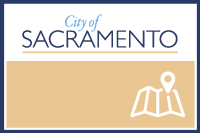

In [4]:
#Let's work with the City Maintained Trees dataset
trees = gis.content.get('b9b716e09b5048179ab648bb4518452b')
trees

In [5]:
#We can clone this to our own account
trees_copy = gis.content.add(trees, data=trees.url, folder="python_api")
trees_copy

<Item title:"City_Maintained_Trees" type:Feature Layer Collection owner:astrng>

In [6]:
# Now let's query this data in pandas
from arcgis.features import FeatureLayer
import pandas as pd

#make query
feature_layer = FeatureLayer.fromitem(trees_copy)
features = feature_layer.query()

#open features in pandas data frame 
df = features.df
df

,ADDRESS_NUMBER,BOTANICAL,CONDUCTOR,CULTIVAR,DBH,GISOBJID,GROWSPACE,HDSCAPE,LANDUSE,NCS,OBJECTID,OBJ_CODE,PLANTTYPE,SPECIES,STEMS,STREET,SHAPE
0,1701,Casuarina equisetifolia,Not Present,None,13 to 18,10012227,6ft+,None,Golf Course,None,1,1,Other - Maintained,horsetail tree,1.0,SUTTERVILLE RD,"{'x': 6704981.192524806, 'y': 1958281.84064379..."
1,1701,Quercus agrifolia,Not Present,None,19 to 24,10123517,6ft+,None,Golf Course,None,2,2,Other - Maintained,"oak, coast live",NaN,SUTTERVILLE RD,"{'x': 6705151.776829317, 'y': 1958298.04303921..."
2,4132,Fraxinus velutina modesto,Not Present,None,19 to 24,10106928,5ft,None,Single Family Residential,None,6,6,Planter Strip,"ash, Modesto",NaN,T ST,"{'x': 6717287.509119481, 'y': 1965300.56643570..."
3,4132,Acer spp,Present - Future conflict,None,4 to 6,10236413,5ft,None,Single Family Residential,None,9,9,Planter Strip,"maple, spp",NaN,T ST,"{'x': 6717276.720427141, 'y': 1965268.19478130..."
4,4133,Lagerstroemia indica,Not Present,None,7 to 12,10106931,5ft,None,Single Family Residential,None,11,11,Planter Strip,crape myrtle,NaN,U ST,"{'x': 6717232.919989809, 'y': 1965146.59922397..."
5,4201,Acer buergeranum,Present - Future conflict,None,4 to 6,10106932,5ft,None,Multi Family Residential,None,12,12,Planter Strip,"maple, trident",NaN,U ST,"{'x': 6717265.551486224, 'y': 1965116.30040004..."
6,4200,Nyssa sylvatica,Not Present,None,4 to 6,10106937,5ft,None,Multi Family Residential,None,17,17,Planter Strip,tupelo / sour gum,NaN,T ST,"{'x': 6717316.598628223, 'y': 1965266.23349912..."
7,3701,Ulmus spp,Not Present,None,7 to 12,10106941,5ft,None,Small Commercial,None,22,22,Planter Strip,"elm, hybrid",NaN,S ST,"{'x': 6716531.959777564, 'y': 1966164.72579662..."
8,3701,Ulmus spp,Not Present,None,7 to 12,10106942,5ft,None,Small Commercial,None,23,23,Planter Strip,"elm, hybrid",NaN,S ST,"{'x': 6716508.141911805, 'y': 1966096.99364863..."
9,1900,Lagerstroemia indica,Not Present,None,4 to 6,10106943,5ft,None,Single Family Residential,None,24,24,Planter Strip,crape myrtle,NaN,39TH ST,"{'x': 6716488.983485565, 'y': 1966033.14075796..."


In [7]:
#Can we calculate carbon storage from the Diameter at Breast Height 'DBH' (i.e., tree diameter measured at 4.5 ft above ground)
DBH = df['DBH']
DBH

0         13 to 18
1         19 to 24
2         19 to 24
3           4 to 6
4          7 to 12
5           4 to 6
6           4 to 6
7          7 to 12
8          7 to 12
9           4 to 6
10        37 to 48
11          4 to 6
12         7 to 12
13         7 to 12
14          4 to 6
15        13 to 18
16          4 to 6
17        25 to 36
18        25 to 36
19          4 to 6
20          4 to 6
21          4 to 6
22          4 to 6
23          4 to 6
24         7 to 12
25        25 to 36
26        25 to 36
27        25 to 36
28        25 to 36
29          0 to 3
            ...   
100520        None
100521        None
100522        None
100523        None
100524        None
100525        None
100526        None
100527      0 to 3
100528     7 to 12
100529        None
100530      0 to 3
100531    13 to 18
100532     7 to 12
100533      4 to 6
100534     7 to 12
100535      4 to 6
100536      0 to 3
100537      0 to 3
100538    19 to 24
100539    19 to 24
100540    25 to 36
100541    13